In [90]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import time
from typing import Optional
import logging
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class BitcoinDataLoader:
    """
    Fetches Bitcoin historical price data from Binance API.

    Attributes:
        base_url (str): Binance API base URL for klines (candles)
        rate_limit_delay (float): Seconds to wait between requests
    """

    def __init__(self, api_key: Optional[str] = None):
        self.base_url = 'https://api.binance.com/api/v3/klines'
        self.api_key = api_key
        self.rate_limit_delay = 0.5  # safe delay for rate limits

    @staticmethod
    def _date_to_ms(date_str: str) -> int:
        """Convert 'YYYY-MM-DD' string to milliseconds timestamp."""
        dt = datetime.strptime(date_str, '%Y-%m-%d')
        return int(dt.timestamp() * 1000)

    def fetch_data(self, 
                   start_date: str, 
                   end_date: str, 
                   frequency: str = '1h', 
                   symbol: str = 'BTCUSDT') -> pd.DataFrame:
        """
        Fetch historical OHLCV data from Binance API.

        Args:
            start_date: Start date in 'YYYY-MM-DD' format
            end_date: End date in 'YYYY-MM-DD' format
            frequency: Binance interval (e.g., '1m', '1h', '1d')
            symbol: Trading pair symbol (default BTCUSDT)
        
        Returns:
            DataFrame with columns: timestamp, open, high, low, close, volume
        """
        start_ts = self._date_to_ms(start_date)
        end_ts = self._date_to_ms(end_date)
        limit = 1000  # Binance max per request
        all_data = []
        current_start = start_ts

        logger.info(f"Fetching {symbol} data from {start_date} to {end_date} (Interval: {frequency})")

        while current_start < end_ts:
            params = {
                'symbol': symbol,
                'interval': frequency,
                'startTime': current_start,
                'endTime': end_ts,
                'limit': limit
            }

            try:
                response = requests.get(self.base_url, params=params)
                response.raise_for_status()
                data = response.json()

                if not data:
                    logger.info("Reached end of available data.")
                    break

                df_chunk = pd.DataFrame(data, columns=[
                    'timestamp', 'open', 'high', 'low', 'close', 'volume',
                    'close_time', 'quote_asset_volume', 'number_of_trades',
                    'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
                ])
                df_chunk = df_chunk[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
                for col in ['open', 'high', 'low', 'close', 'volume']:
                    df_chunk[col] = pd.to_numeric(df_chunk[col], errors='coerce')

                all_data.append(df_chunk)
                current_start = df_chunk['timestamp'].iloc[-1] + 1
                latest_ts = pd.to_datetime(df_chunk['timestamp'].max(), unit='ms')
                logger.info(f"Fetched up to {latest_ts.strftime('%Y-%m-%d %H:%M:%S')} ({len(df_chunk)} records)")
                time.sleep(self.rate_limit_delay)

            except requests.exceptions.RequestException as e:
                logger.error(f"Error fetching data: {e}. Waiting 5 seconds...")
                time.sleep(5)
                continue

        if not all_data:
            logger.warning("No data fetched.")
            return pd.DataFrame()

        df = pd.concat(all_data, ignore_index=True)
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.drop_duplicates(subset=['timestamp'], inplace=True)
        df.sort_values('timestamp', inplace=True)
        end_dt = datetime.strptime(end_date, '%Y-%m-%d') + timedelta(days=1)
        df = df[(df['timestamp'] >= pd.to_datetime(start_date)) & (df['timestamp'] < end_dt)]
        df = df.reset_index(drop=True)

        logger.info(f"Successfully fetched {len(df)} final records from {df['timestamp'].min()} to {df['timestamp'].max()}")
        return df

    def save_data(self, df: pd.DataFrame, filepath: str):
        """Save data to CSV file."""
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        df.to_csv(filepath, index=False)
        logger.info(f"Data saved to {filepath}")

    def load_data(self, filepath: str) -> pd.DataFrame:
        """Load data from CSV file."""
        df = pd.read_csv(filepath)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.set_index('timestamp')
        logger.info(f"Loaded {len(df)} records from {filepath}")
        return df

# Example usage
if __name__ == "__main__":
    loader = BitcoinDataLoader()
    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = (datetime.now() - timedelta(days=365*2)).strftime('%Y-%m-%d')  # last 2 years hourly
    df = loader.fetch_data(start_date, end_date, frequency='1h')
    print(df.head())
    loader.save_data(df, 'data/raw/bitcoin_2y_hourly.csv')


INFO:__main__:Fetching BTCUSDT data from 2023-11-28 to 2025-11-27 (Interval: 1h)
INFO:__main__:Fetched up to 2024-01-08 11:00:00 (1000 records)
INFO:__main__:Fetched up to 2024-02-19 03:00:00 (1000 records)
INFO:__main__:Fetched up to 2024-03-31 19:00:00 (1000 records)
INFO:__main__:Fetched up to 2024-05-12 11:00:00 (1000 records)
INFO:__main__:Fetched up to 2024-06-23 03:00:00 (1000 records)
INFO:__main__:Fetched up to 2024-08-03 19:00:00 (1000 records)
INFO:__main__:Fetched up to 2024-09-14 11:00:00 (1000 records)
INFO:__main__:Fetched up to 2024-10-26 03:00:00 (1000 records)
INFO:__main__:Fetched up to 2024-12-06 19:00:00 (1000 records)
INFO:__main__:Fetched up to 2025-01-17 11:00:00 (1000 records)
INFO:__main__:Fetched up to 2025-02-28 03:00:00 (1000 records)
INFO:__main__:Fetched up to 2025-04-10 19:00:00 (1000 records)
INFO:__main__:Fetched up to 2025-05-22 11:00:00 (1000 records)
INFO:__main__:Fetched up to 2025-07-03 03:00:00 (1000 records)
INFO:__main__:Fetched up to 2025-08-1

            timestamp      open      high       low     close     volume
0 2023-11-28 00:00:00  37242.70  37343.57  37191.10  37258.13  938.57779
1 2023-11-28 01:00:00  37258.14  37266.19  37164.00  37198.09  698.60814
2 2023-11-28 02:00:00  37198.09  37209.33  37123.00  37179.11  482.94463
3 2023-11-28 03:00:00  37179.10  37199.91  37102.47  37129.56  440.60332
4 2023-11-28 04:00:00  37129.55  37146.00  36978.82  36988.00  785.21641


In [91]:
df.shape

(17517, 6)

In [92]:
"""
Data validation module for Bitcoin price data.

Performs quality checks to identify issues like missing values,
duplicates, outliers, and suspicious patterns.
"""

import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional
from datetime import datetime, timedelta 
import logging
import os
import requests  # Required for Data Loader
import time      # Required for Data Loader

# Configure logging to ensure visibility of warnings and errors
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# =========================================================================
# === PART 1: DATA LOADER CODE (included to avoid ModuleNotFoundError) ===
# =========================================================================

class BitcoinDataLoader:
    """ Fetches and loads Bitcoin historical price data. """

    def __init__(self, api_key: Optional[str] = None):
        self.base_url = 'https://api.binance.com/api/v3/klines'
        self.api_key = api_key
        self.rate_limit_delay = 0.5

    # Only implementing load_data to work with local CSV for validation
    def load_data(self, filepath: str) -> pd.DataFrame:
        """Load data from CSV file."""
        if not os.path.exists(filepath):
            logger.error(f"File not found at {filepath}. Cannot validate.")
            raise FileNotFoundError(f"Data file not found at {filepath}")
            
        df = pd.read_csv(filepath)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.set_index('timestamp')
        
        # Ensure numeric columns are properly converted
        for col in ['open', 'high', 'low', 'close', 'volume']:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
        logger.info(f"Loaded {len(df)} records from {filepath}")
        return df

# =========================================================================
# === PART 2: DATA VALIDATOR CODE ===
# =========================================================================

class DataValidator:
    """
    Validates data quality for time series forecasting.
    """
    
    def __init__(self):
        self.max_price_change = 1.0  
        self.min_volume = 0.0
        
    @staticmethod
    def _get_ohlcv_cols() -> List[str]:
        return ['open', 'high', 'low', 'close', 'volume']
        
    def validate(self, df: pd.DataFrame) -> Dict:
        issues = []
        
        if not pd.api.types.is_datetime64_any_dtype(df.index):
             raise TypeError("DataFrame index must be a datetime index for validation.")

        # Call all individual check methods
        issues.extend(self._check_duplicates(df))
        issues.extend(self._check_missing_values(df))
        issues.extend(self._check_gaps(df))
        issues.extend(self._check_invalid_prices(df))
        issues.extend(self._check_ohlc_relationships(df))
        issues.extend(self._check_outliers(df))
        
        # Compile metrics
        metrics = {}
        metrics['total_records'] = len(df)
        metrics['date_range_start'] = df.index.min().strftime('%Y-%m-%d %H:%M:%S')
        metrics['date_range_end'] = df.index.max().strftime('%Y-%m-%d %H:%M:%S')
        metrics['num_issues'] = len(issues)
        
        # Determine overall validity
        is_valid = len(issues) == 0
        
        # Generate summary report
        summary = self._generate_summary(is_valid, issues, metrics)
        
        return {
            'is_valid': is_valid, 'issues': issues, 'metrics': metrics, 'summary': summary
        }
    
    def _check_missing_values(self, df: pd.DataFrame) -> List[str]:
        issues = []
        missing_counts = df[self._get_ohlcv_cols()].isnull().sum()
        
        for col, count in missing_counts.items():
            if count > 0:
                issues.append(f"Missing Values: Column '{col}' has {count} NaN values.")
        
        return issues
        
    def _check_duplicates(self, df: pd.DataFrame) -> List[str]:
        issues = []
        duplicates_count = df.index.duplicated().sum()
        
        if duplicates_count > 0:
            issues.append(f"Duplicate Timestamps: Found {duplicates_count} duplicate index entries (timestamps).")
            
        return issues
        
    def _check_invalid_prices(self, df: pd.DataFrame) -> List[str]:
        issues = []
        price_cols = ['open', 'high', 'low', 'close']
        
        for col in price_cols:
            invalid_count = (df[col] <= 0).sum()
            if invalid_count > 0:
                issues.append(f"Invalid Price: Column '{col}' has {invalid_count} values <= 0.")
                
        volume_invalid_count = (df['volume'] < self.min_volume).sum()
        if volume_invalid_count > 0:
             issues.append(f"Invalid Volume: Column 'volume' has {volume_invalid_count} negative values.")
             
        return issues
        
    def _check_ohlc_relationships(self, df: pd.DataFrame) -> List[str]:
        issues = []
        violation_counts = {
            "High < Low": (df['high'] < df['low']).sum(),
            "High < Open": (df['high'] < df['open']).sum(),
            "High < Close": (df['high'] < df['close']).sum(),
            "Low > Open": (df['low'] > df['open']).sum(),
            "Low > Close": (df['low'] > df['close']).sum()
        }
        
        for check, count in violation_counts.items():
            if count > 0:
                issues.append(f"OHLC Violation: {count} records found where {check}.")

        return issues
        
    def _check_gaps(self, df: pd.DataFrame) -> List[str]:
        issues = []
        df_sorted = df.sort_index()
        time_diffs = df_sorted.index.to_series().diff().dropna()
        
        if time_diffs.empty: 
            return issues
            
        try:
            mode_interval = time_diffs.value_counts().idxmax()
        except ValueError:
            logger.warning("Could not determine a mode interval for gap check.")
            return issues
            
        gap_threshold = mode_interval * 1.5
        gaps = time_diffs[time_diffs > gap_threshold]
        
        if not gaps.empty:
            issues.append(f"Time Gaps: Found {len(gaps)} records with intervals > {gap_threshold}. Mode interval is {mode_interval}.")

        return issues
        
    def _check_outliers(self, df: pd.DataFrame) -> List[str]:
        issues = []
        returns = pd.to_numeric(df['close'], errors='coerce').pct_change().dropna()
        extreme_movements = returns[returns.abs() > self.max_price_change]
        
        if not extreme_movements.empty:
            issues.append(f"Extreme Outliers: Found {len(extreme_movements)} records with single-candle price change > {self.max_price_change*100:.0f}%.")
            
        return issues
        
    def _generate_summary(self, is_valid: bool, issues: List[str], metrics: Dict) -> str:
        status = "PASSED" if is_valid else "FAILED"
        
        summary = f"""
        {'-' * 50}
        DATA VALIDATION REPORT
        {'-' * 50}
        Overall Status: {status}
        
        --- Metrics ---
        Total Records: \t\t{metrics.get('total_records', 'N/A')}
        Start Date: \t\t{metrics.get('date_range_start', 'N/A')}
        End Date: \t\t{metrics.get('date_range_end', 'N/A')}
        Total Issues Found: \t{metrics.get('num_issues', 0)}
        
        --- Issues Breakdown ---
        """
        
        if issues:
            for issue in issues:
                summary += f"• {issue}\n"
        else:
            summary += "No critical data quality issues found.\n"
            
        summary += f"\n{'=' * 50}"
        return summary

# =========================================================================
# === PART 3: EXECUTION BLOCK ===
# =========================================================================

if __name__ == "__main__":
    
    filepath = 'data/raw/bitcoin_2y_hourly.csv'

    try:
        print(f"Loading data for validation from: {filepath}")
        loader = BitcoinDataLoader()
        df = loader.load_data(filepath)
        
        # Validate data
        validator = DataValidator()
        results = validator.validate(df)
        
        # Print summary report
        print(results['summary'])
        
        if not results['is_valid']:
            logger.error("Data validation found issues. Review the 'Issues Breakdown' section.")
        else:
            logger.info("Data has been validated successfully. No critical data quality issues found.")
             
    except FileNotFoundError as e:
        print(f"CRITICAL ERROR: Data file ('{filepath}') not found. Ensure previous steps ran successfully and data was saved.")
    except Exception as e:
        print(f"CRITICAL ERROR during validation: {e}")


INFO:__main__:Loaded 17517 records from data/raw/bitcoin_2y_hourly.csv
INFO:__main__:Data has been validated successfully. No critical data quality issues found.


Loading data for validation from: data/raw/bitcoin_2y_hourly.csv

        --------------------------------------------------
        DATA VALIDATION REPORT
        --------------------------------------------------
        Overall Status: PASSED
        
        --- Metrics ---
        Total Records: 		17517
        Start Date: 		2023-11-28 00:00:00
        End Date: 		2025-11-26 20:00:00
        Total Issues Found: 	0
        
        --- Issues Breakdown ---
        No critical data quality issues found.



In [103]:
print("=== BASIC INFO ===")
df.info()
print("\n=== SUMMARY STATISTICS ===")
print(df.describe())

=== BASIC INFO ===
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17517 entries, 2023-11-28 00:00:00 to 2025-11-26 20:00:00
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   open               17517 non-null  float64
 1   high               17517 non-null  float64
 2   low                17517 non-null  float64
 3   close              17517 non-null  float64
 4   volume             17517 non-null  float64
 5   close_z            17517 non-null  float64
 6   close_rolling_std  17494 non-null  float64
 7   hour               17517 non-null  int32  
dtypes: float64(7), int32(1)
memory usage: 1.6 MB

=== SUMMARY STATISTICS ===
                open           high            low          close  \
count   17517.000000   17517.000000   17517.000000   17517.000000   
mean    81527.493530   81797.219447   81247.012327   81530.498049   
std     23898.635069   23944.035258   23851.832103   23896.376975   
min 

In [104]:
# Missing values
print("\n=== Missing values ===")
print(df.isna().sum())


=== Missing values ===
open                  0
high                  0
low                   0
close                 0
volume                0
close_z               0
close_rolling_std    23
hour                  0
dtype: int64


In [105]:
# Duplicates
duplicate_count = df.index.duplicated().sum()
print(f"\nDuplicate timestamps: {duplicate_count}")



Duplicate timestamps: 0


In [106]:
#Outliers (simple method using z-score for close price)
from scipy.stats import zscore
df['close_z'] = zscore(df['close'])
outliers = df[np.abs(df['close_z']) > 3]
print(f"\nNumber of extreme outliers (z>3): {len(outliers)}")



Number of extreme outliers (z>3): 0


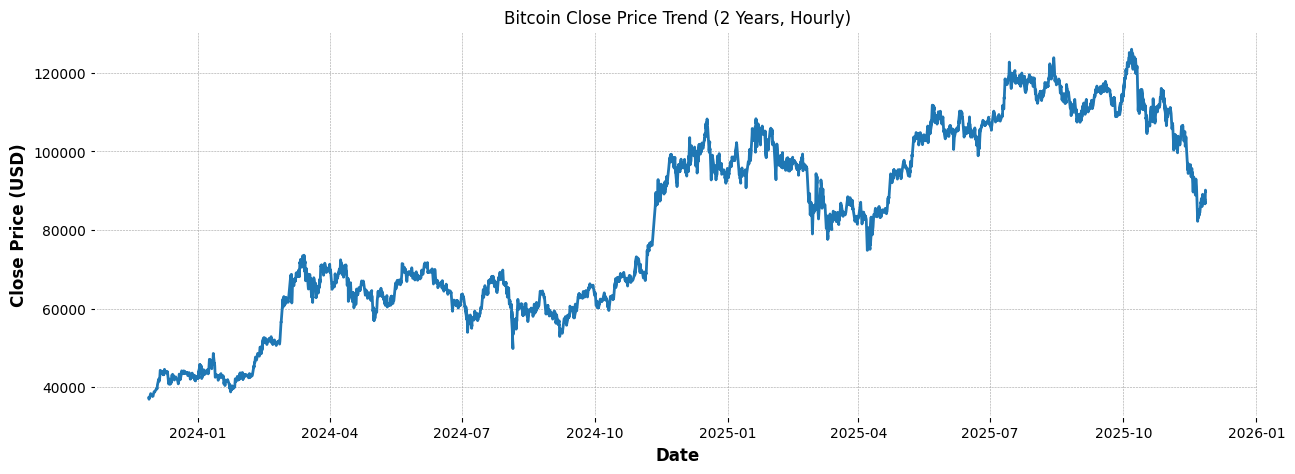

In [107]:
# Time trends
plt.figure(figsize=(15,5))
plt.plot(df['close'])
plt.title("Bitcoin Close Price Trend (2 Years, Hourly)")
plt.ylabel("Close Price (USD)")
plt.xlabel("Date")
plt.show()


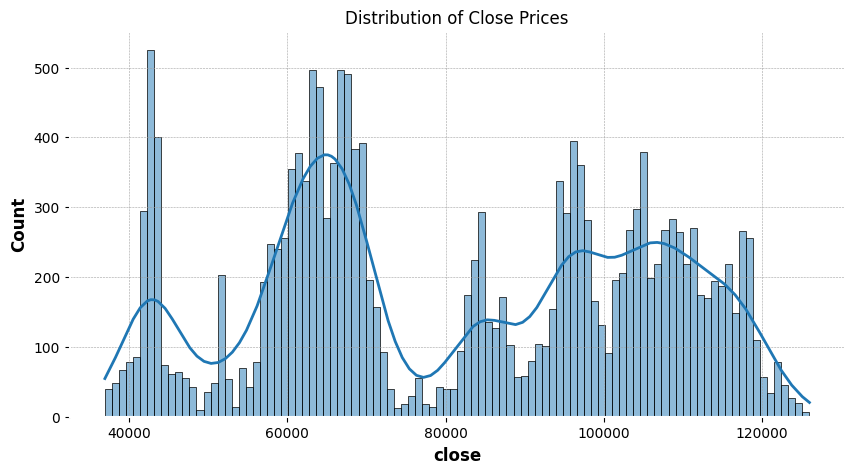

In [108]:
# Distribution of prices
plt.figure(figsize=(10,5))
sns.histplot(df['close'], bins=100, kde=True)
plt.title("Distribution of Close Prices")
plt.show()


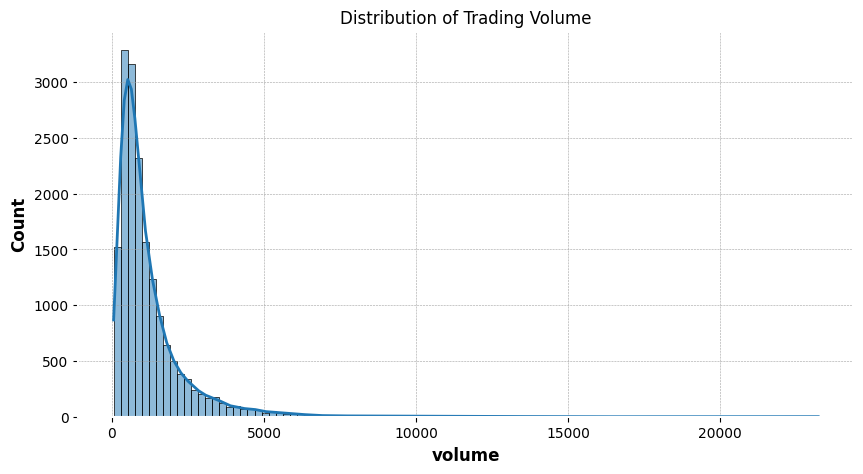

In [109]:
# Volume distribution
plt.figure(figsize=(10,5))
sns.histplot(df['volume'], bins=100, kde=True)
plt.title("Distribution of Trading Volume")
plt.show()

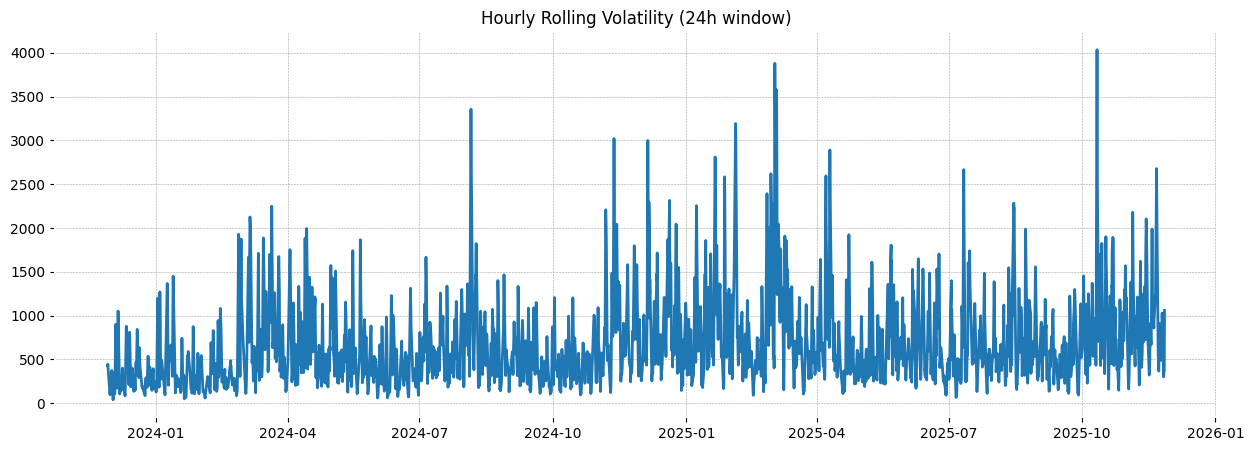

In [110]:
# Volatility pattern (rolling std)
df['close_rolling_std'] = df['close'].rolling(window=24).std()  # 24h rolling
plt.figure(figsize=(15,5))
plt.plot(df['close_rolling_std'])
plt.title("Hourly Rolling Volatility (24h window)")
plt.show()

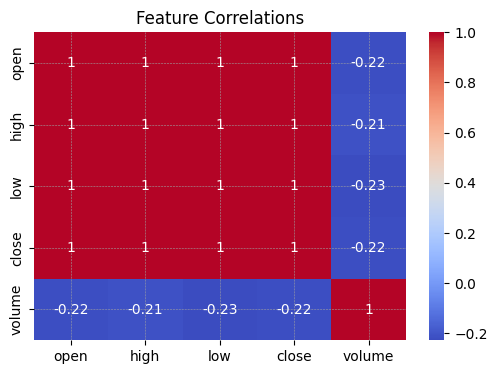

In [111]:
# Correlations
corr = df[['open','high','low','close','volume']].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlations")
plt.show()